# i was group E, number 4 in the array

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'retina'
from IPython.display import display, Math, Markdown
import scipy.optimize as opt
import satm

In [34]:
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
weights = [pd.read_excel("./OneDrive_1_27-10-2023/weights.xlsx", groups[i]) for i in range(len(groups))]
drag = [pd.read_excel("./OneDrive_1_27-10-2023/drag.xlsx", groups[i]) for i in range(len(groups))]
static = [pd.read_excel("./OneDrive_1_27-10-2023/LSS.xlsx", groups[i]) for i in range(len(groups))]
maneuvre = [pd.read_excel("./OneDrive_1_27-10-2023/LMS.xlsx", groups[i]) for i in range(len(groups))]
sideslip = [pd.read_excel("./OneDrive_1_27-10-2023/SHSS.xlsx", groups[i]) for i in range(len(groups))]
masses = pd.read_excel("./OneDrive_1_27-10-2023/masses.xlsx")

In [35]:
def B_1(L, V, S=41.8, rho=1.225):
    '''coefficient of lift or drag'''
    denominator = rho * V * V * S
    return 2*L/denominator

def kt_to_ms(kt):
    return kt * 0.51444

def ft_to_m(ft):
    return ft * 0.3048

g = 9.80665
T0 = 288.15
p0 = 101325.0
rho0 = 1.225
S = 41.8

def B_3(V_e, theta, delta):
    '''calculates true airspeed, takes in EAS, temperature ratio and pressure ratio'''
    return V_e * np.sqrt(theta/delta)

datum_dist = [10.69, 11.18, 6.91, 7.87, 8.61, 9.34, 10.08, 10.82, 11.73, 12.49, 13.23, 13.96, 14.70, 15.49, 17.12]

In [36]:
def mass(group):
    """drag and performance question 1"""
    # 8695 is the dry weight
    mass_nofuel = sum(weights[group]["A"]) + sum(weights[group]["B"]) + sum(weights[group]["C"]) + 8695
    
    # find the average fuel mass
    start = drag[group]["Fuel Quantity LH [kg]"][0] + drag[group]["Fuel Quantity RH [kg]"][0]
    end = drag[group]["Fuel Quantity LH [kg]"][len(drag[group]["Fuel Quantity LH [kg]"]) - 1] + drag[group]["Fuel Quantity RH [kg]"][len(drag[group]["Fuel Quantity RH [kg]"]) - 1]
    average = start+end / 2
    mass = mass_nofuel + average
    return mass


In [38]:
"""make sure all of the masses are below MTOW"""
for i in range(len(groups)):
    assert mass(i) < 13155

In [39]:
dap_1 = []
for i in range(len(groups)):
    display(Markdown(rf"Group ${groups[i]}$ had a weight of ${mass(i):6.2f}kg$"))
    dap_1.append(mass(i))

Group $A$ had a weight of $12591.47kg$

Group $B$ had a weight of $12182.07kg$

Group $C$ had a weight of $12701.80kg$

Group $D$ had a weight of $12213.39kg$

Group $E$ had a weight of $12768.96kg$

Group $F$ had a weight of $12273.00kg$

Group $G$ had a weight of $12760.89kg$

Group $H$ had a weight of $11998.10kg$

In [40]:
def coeffs(group):
    final = []
    for i in range(len(drag[group]["IAS [kt]"])):
        velocity = drag[group]["IAS [kt]"][i]
        c_l = B_1(mass(group)*9.81, velocity)

        t_total = drag[group]["Thrust LH [N]"][i] + drag[group]["Thrust RH [N]"][i]
        c_d = B_1(t_total, velocity)

        output = {
            "group": group,
            "velocity": velocity,
            "c_l": c_l,
            "c_d": c_d,
        }
        final.append(output)
    return final

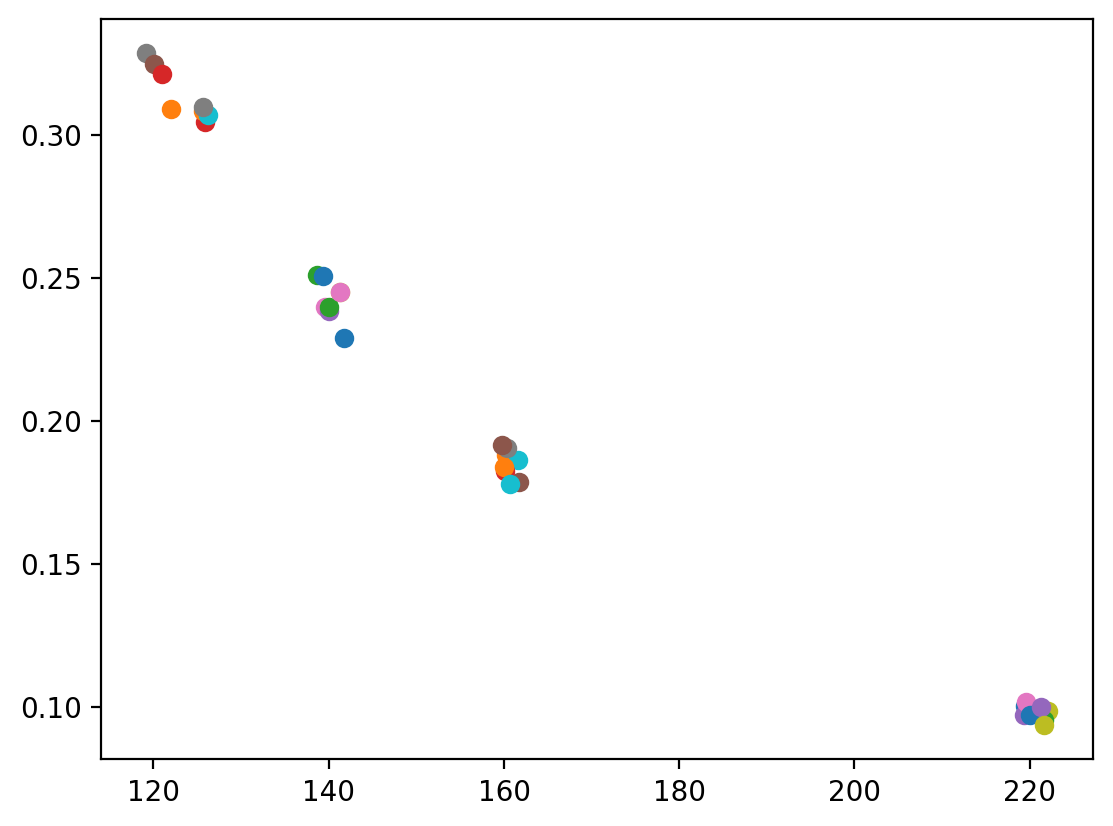

In [41]:
dap_2 = []
for i in range(len(groups)):
    dap_2 += coeffs(i)
[plt.scatter(d['velocity'], d['c_l']) for d in dap_2]
plt.show()

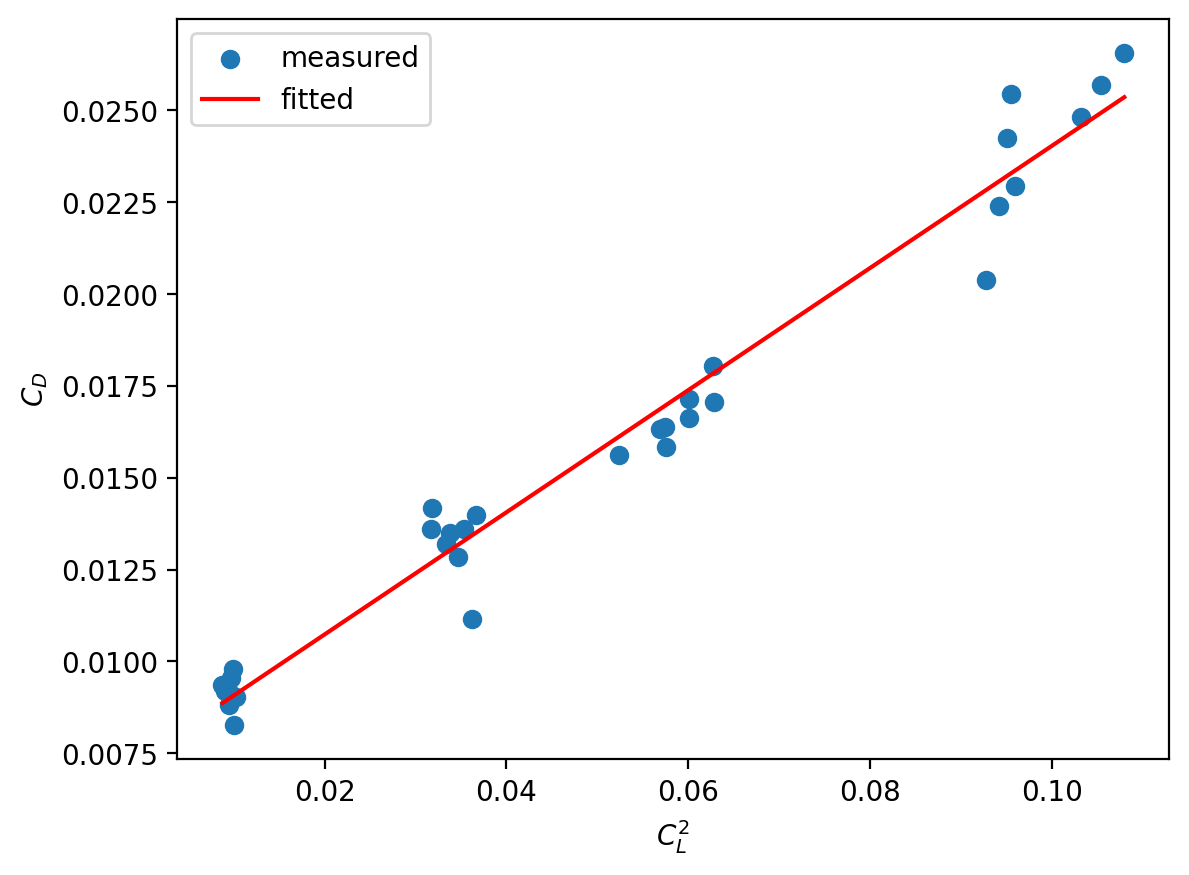

In [42]:
def linear(x, m, c):
    '''linear curve fit model for scipy'''
    return m*x + c


def dap_3(plot = True):
    '''combining the code for q3, cant really just return a variable'''
    # gathering data
    cls = []
    cds = []
    [(cls.append(d['c_l']**2), cds.append(d['c_d'])) for d in dap_2]
    
    # plotting data
    plt.scatter(cls, cds, label="measured")
    plt.xlabel(r"$C_L^2$")
    plt.ylabel(r"$C_D$")
    
    # getting coeffs
    (K, cd0) = opt.curve_fit(linear, cls, cds)[0]
    
    if plot:
        xs = np.linspace(min(cls), max(cls))
        plt.plot(xs, linear(xs, K, cd0), color="r", label="fitted")
    
    plt.legend()
    return (K, cd0)
    
    
(K, cd0) = dap_3()

In [43]:
dap_4 = np.sqrt(cd0/K)

In [44]:
dap_5 = np.sqrt((2 * mass(4) * 9.81)/(1.225 * dap_4 * S))

Equation $2.44$ gives ${L\over D}_{max}$ as $ 2.37$

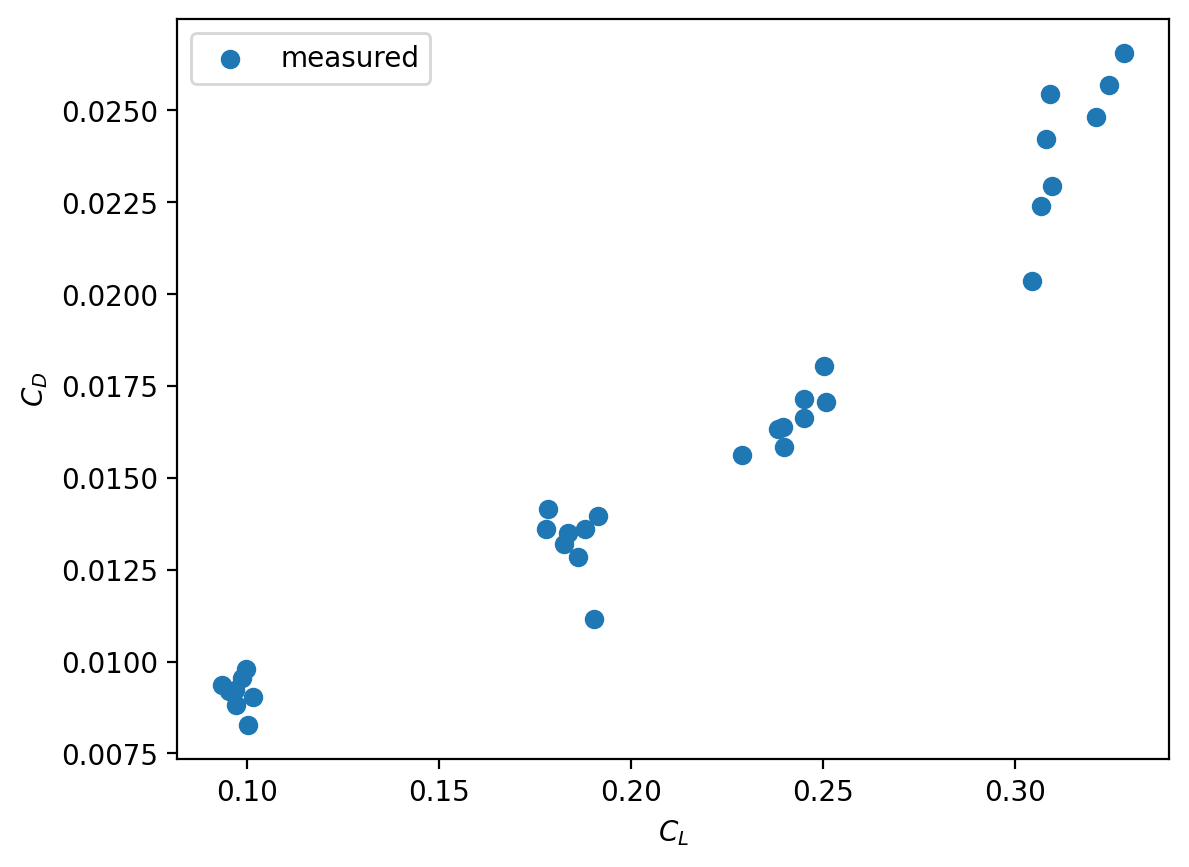

In [45]:
def dap_6():
    '''its graph time again yippee'''
    # gathering data
    cls = []
    cds = []
    [(cls.append(d['c_l']), cds.append(d['c_d'])) for d in dap_2]
    
    # plotting data
    plt.scatter(cls, cds, label="measured")
    plt.xlabel(r"$C_L$")
    plt.ylabel(r"$C_D$")

    plt.legend()
    
    display(Markdown("Equation $2.44$ gives ${L\over D}_{max}$ as " + f"${0.5 * np.sqrt(1/cd0 * K): 1.2f}$"))
    
dap_6()

it does kinda look like $\frac{L}{D}_{max}$ is between $0.2$ and $0.25$, this is where the gradient is at a minimum

In [14]:
def dap_789(group):
    
    '''i grouped these together because 9 needed 7 and 8 and it made sense to me'''
    
    alts = ft_to_m(drag[group]["Pressure Altitude [ft]"])
    params = [satm.get_parameters(alt) for alt in alts]
    temps = np.array([p[0]/T0 for p in params])
    pressures = np.array([p[1]/p0 for p in params])
    rhos = [p[2] for p in params]
    
    EAS = kt_to_ms(drag[group]['IAS [kt]'])
    
    TASes = np.array(B_3(EAS, temps, pressures))
    return pressures, temps, TASes
dap_789(4)

(array([0.77175023, 0.77183813, 0.77180883, 0.77175023]),
 array([0.9518984 , 0.95191903, 0.95191215, 0.9518984 ]),
 array([125.41718064,  91.59700334,  80.70765207,  72.14009193]))

[None, None, None, None, None, None, None, None]

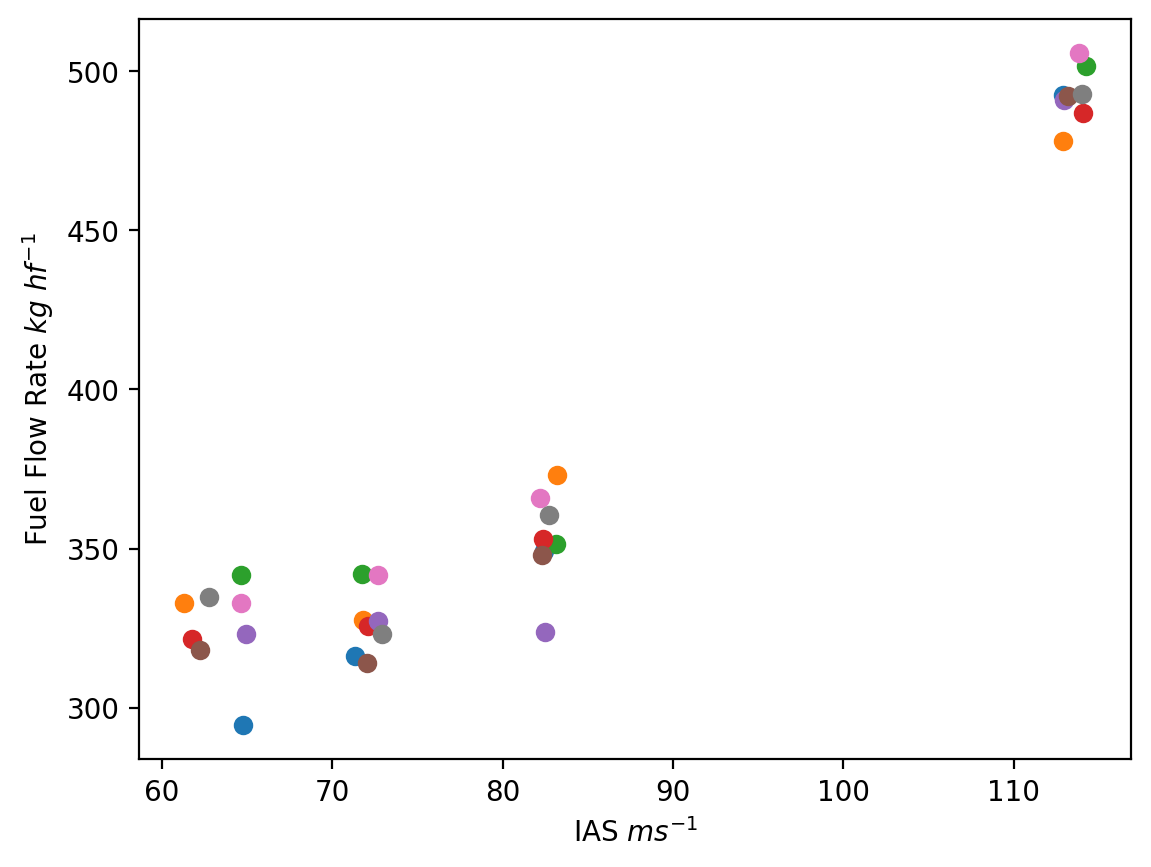

In [15]:
def dap_10(group):
    FFR_r = drag[group]["Fuel Flow Rate LH [kg/hr]"]
    FFR_l = drag[group]["Fuel Flow Rate RH [kg/hr]"]
    FFR = FFR_r + FFR_l
    
    V_e = kt_to_ms(drag[group]["IAS [kt]"])
    
    plt.scatter(V_e, FFR)
    plt.xlabel(r"IAS $ms^{-1}$")
    plt.ylabel(r"Fuel Flow Rate $kg\ hf^{-1}$")

[dap_10(i) for i in range(len(groups))]

i guess $V_{BE}$ is just as low as possible?

Text(0, 0.5, 'SAR')

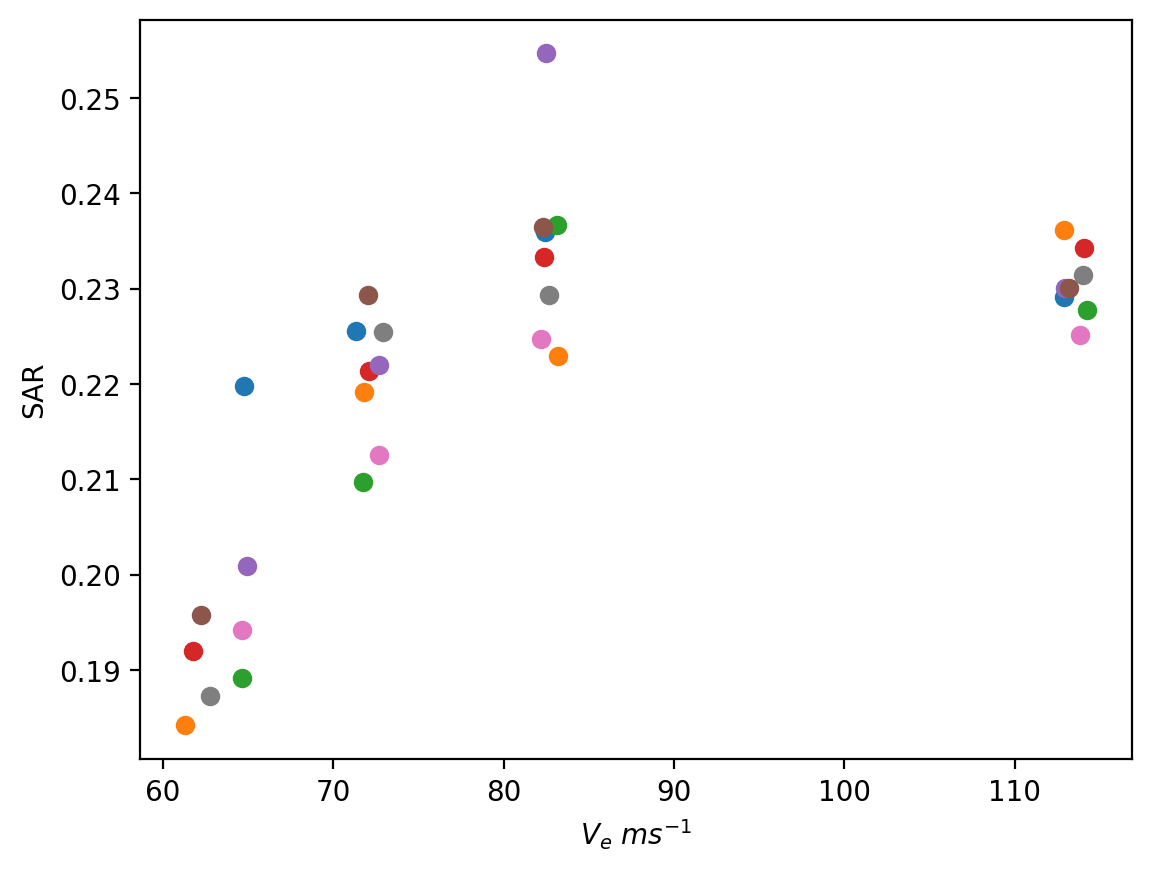

In [16]:
def dap_11(group):
    FFR = drag[group]["Fuel Flow Rate LH [kg/hr]"] + drag[group]["Fuel Flow Rate RH [kg/hr]"]
    V_e = kt_to_ms(drag[group]["IAS [kt]"])
    return V_e/FFR, V_e

for group in range(len(groups)):
    sar, v = dap_11(group)
    plt.scatter(v, sar)
plt.xlabel(r"$V_e\ ms^{-1}$")
plt.ylabel("SAR")

In [17]:
def dap_12():
    raise skillIssue


# longitudinal static and maneouvre stability

In [46]:
def S1(group):
    '''should be 24-31'''
    all_weights = list(weights[group]["A"]+weights[group]["B"]+weights[group]["C"])

    average = np.mean(drag[group]["Fuel Quantity LH [kg]"]) + np.mean(drag[group]["Fuel Quantity RH [kg]"][0])

    all_weights.insert(0, average)
    all_weights.insert(0, 8695)

    all_weights = np.array(all_weights)
    #print(all_weights)
    
    moments = sum(all_weights * datum_dist)/sum(all_weights)
    return (moments-10.472)*(100/2.085)


In [47]:
[S1(i) for i in range(len(groups))]

[28.975059893343687,
 28.228962789320974,
 27.713777248773503,
 24.19556074621476,
 31.17105718557435,
 29.858432667535677,
 25.722002973553337,
 28.22065343265596]

In [48]:
S2 = []
for i in range(len(groups)):
    mass_nofuel = sum(weights[i]["A"]) + sum(weights[i]["B"]) + sum(weights[i]["C"]) + 8695 # fixed
    mass_fuel = static[i]["Fuel Quantity LH [kg]"] + static[i]["Fuel Quantity RH [kg]"]
    mass_total = mass_nofuel + mass_fuel

    speeds = [kt_to_ms(static[i]["IAS [kt]"])]

    C_w = [2 * mass_total[j] * g / (rho0 * speeds[j] * speeds[j] * S) for j in range(len(speeds))]
    S2.append(C_w)

In [49]:
S2[4]

[0    0.538479
 1    0.683607
 2    0.429574
 Name: IAS [kt], dtype: float64]

In [50]:
def S3(group, out = True):
    C_w = np.array(S2[group])[0]
    #C_w = np.sort(C_w)
    eta = np.array(static[group]["Mean Elev"])
    #eta = np.sort(eta)
    if out:
        return [C_w, eta]
    else:
        plt.scatter(C_w, eta)
        plt.xlabel(r"$C_w$")
        plt.ylabel(r"$\eta$")
S3(4)

[array([0.5384789 , 0.68360666, 0.42957353]),
 array([ 0.09635, -0.83365,  0.83895])]

In [51]:
def S4():
    C_w = [S3(i, True)[0] for i in range(len(groups))]
    eta = [S3(i, True)[1] for i in range(len(groups))]

    #slopes should be negative
    slopes = [np.mean(np.gradient(eta[i], C_w[i])) for i in range(len(C_w))]
    C_G = [S1(group) for group in range(len(groups))]
    plt.scatter(C_G, slopes)
    m, c = opt.curve_fit(linear, C_G, slopes)[0]
    x = np.linspace(24, 31)
    plt.plot(x, m*x + c)
    print(f"stick fixed neutral point is {-c/m}% MAC")

[None, None, None, None, None, None, None, None]

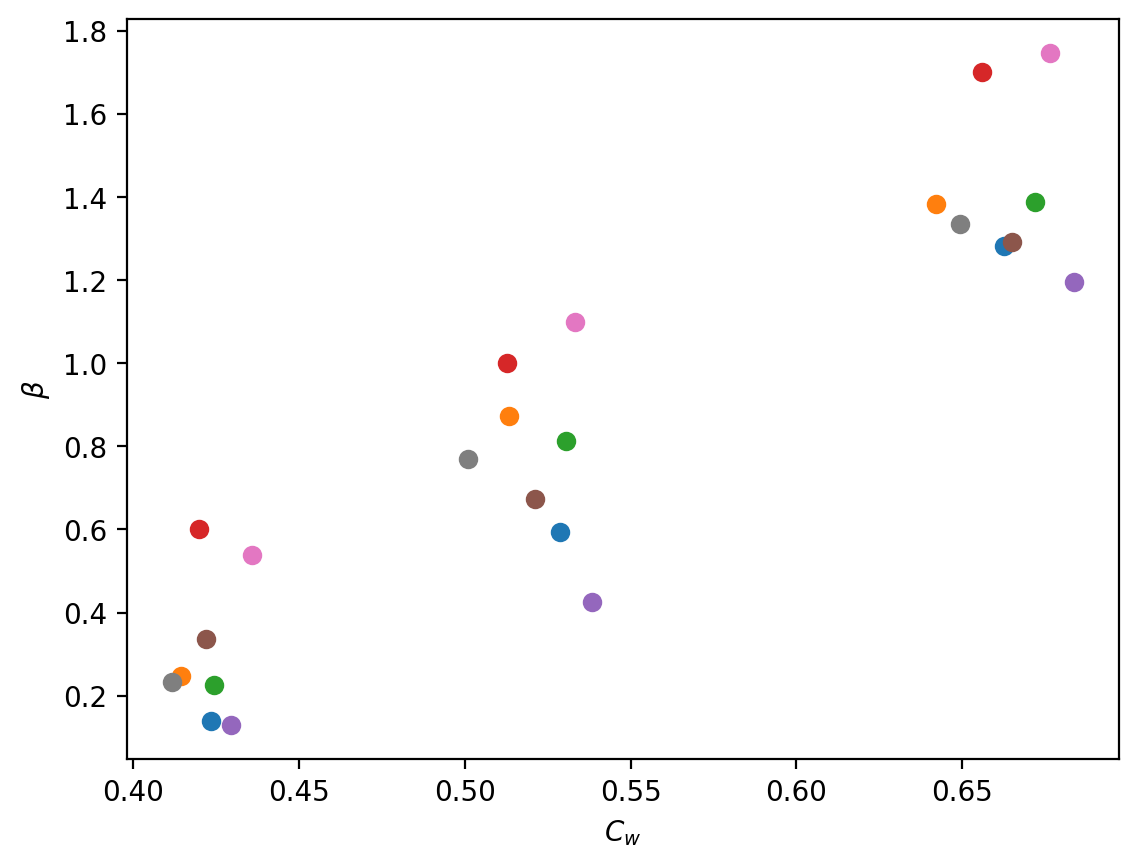

In [52]:
def S5(group, out = False):
    C_w = np.array(S2[group])[0]
    #C_w = np.sort(C_w)
    eta = np.array(static[group]["Trim Deflection [°]"])
    #eta = np.sort(eta)
    if out:
        return [C_w, eta]
    else:
        plt.scatter(C_w, eta)
        plt.xlabel(r"$C_w$")
        plt.ylabel(r"$\beta$")
[S5(i) for i in range(len(groups))]

stick fixed neutral point is -67.39765325766174% MAC


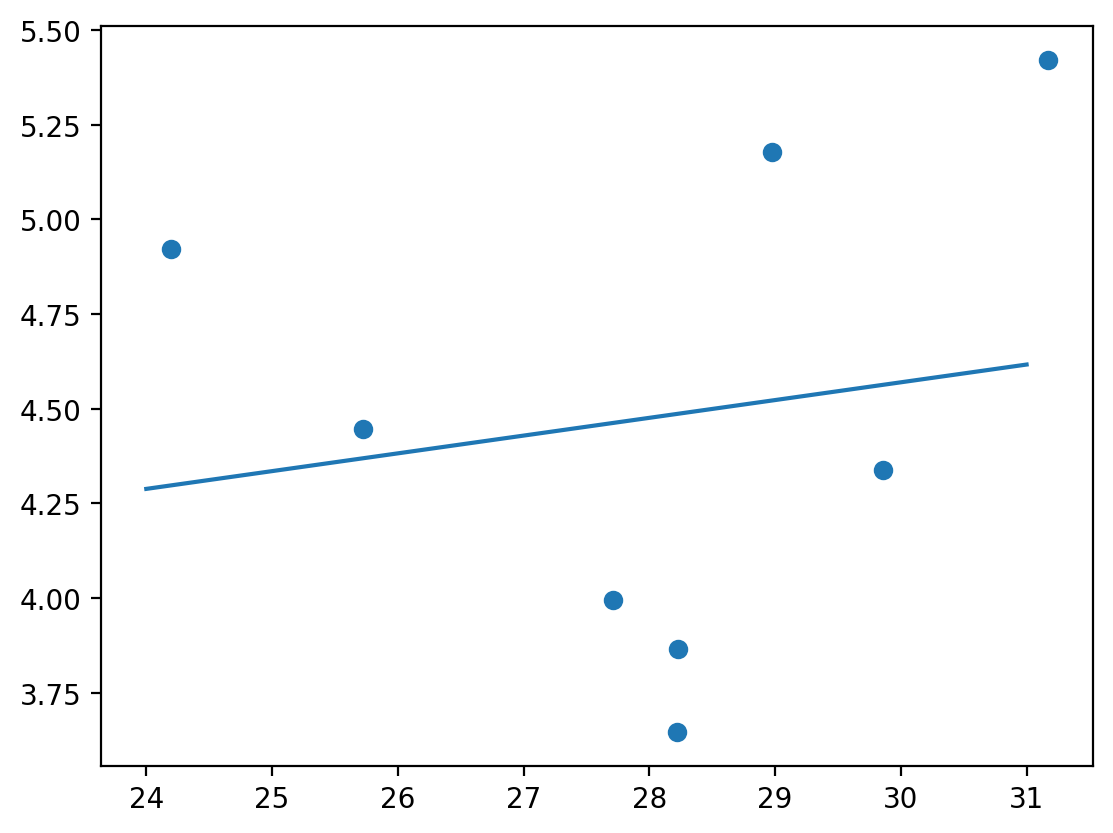

In [53]:
def S6():
    C_w = [S5(i, True)[0] for i in range(len(groups))]
    beta = [S5(i, True)[1] for i in range(len(groups))]

    #slopes should be negative
    slopes = [np.mean(np.gradient(beta[i], C_w[i])) for i in range(len(C_w))]
    C_G = [S1(group) for group in range(len(groups))]
    plt.scatter(C_G, slopes)
    m, c = opt.curve_fit(linear, C_G, slopes)[0]
    x = np.linspace(24, 31)
    plt.plot(x, m*x + c)
    print(f"stick fixed neutral point is {-c/m}% MAC")
S6()

(-0.1510348675141284, 0.9166409307816837)

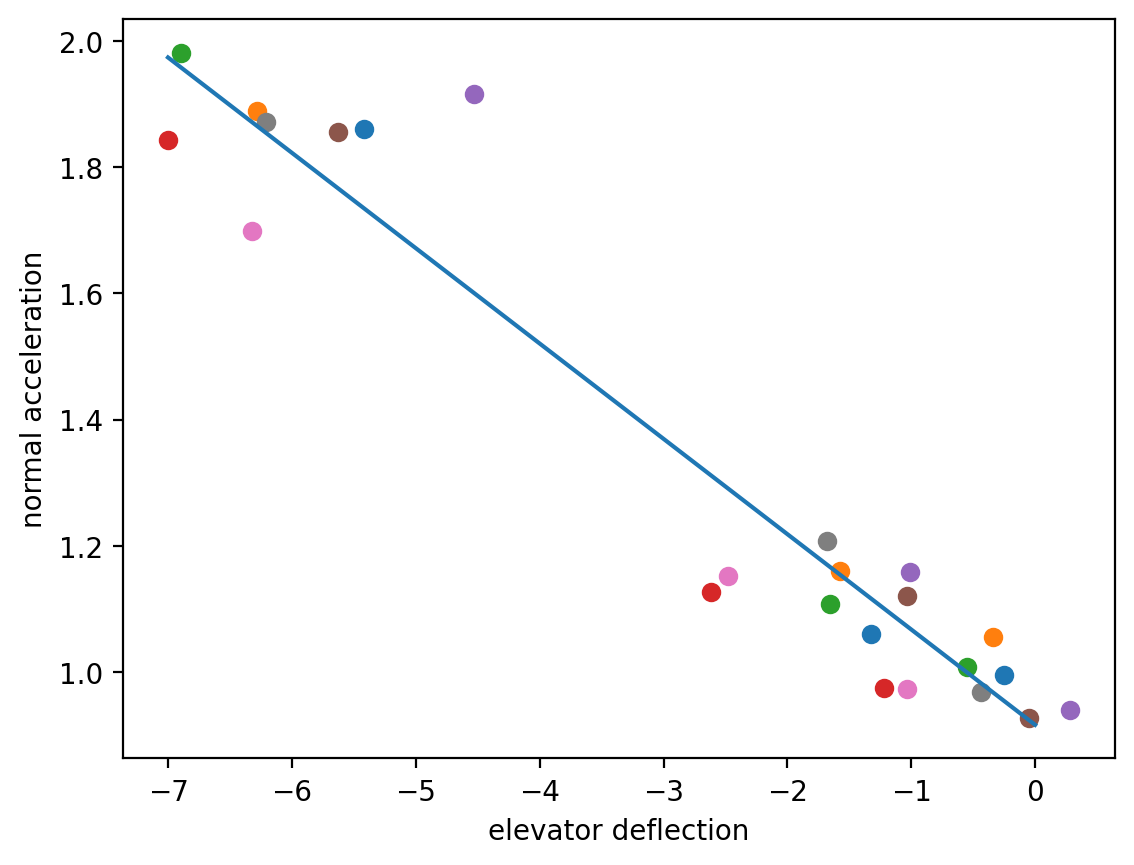

In [111]:
def M1(group, all_groups=True):
    all_eta = []
    all_g = []
    if all_groups:
        for group in range(len(groups)):
            eta = np.array(maneuvre[group]["Mean Elev"])
            n = np.array(maneuvre[group]["Normal Acceleration [g]"])
            for e in eta:
                all_eta.append(e)
            for g in n:
                all_g.append(g)
            plt.scatter(eta, n)
            
        plt.xlabel("elevator deflection")
        plt.ylabel("normal acceleration")
    else:
        eta = np.array(maneuvre[group]["Mean Elev"])
        n = np.array(maneuvre[group]["Normal Acceleration [g]"])
        for e in eta:
            all_eta.append(e)
        for g in n:
            all_g.append(g)
    (m, c) = opt.curve_fit(linear, all_eta, all_g)[0]
    
    if all_groups:
        plt.plot(np.linspace(-7, 0),linear(np.linspace(-7, 0), m, c))
        pass
    return (m, c)

M1(10000)

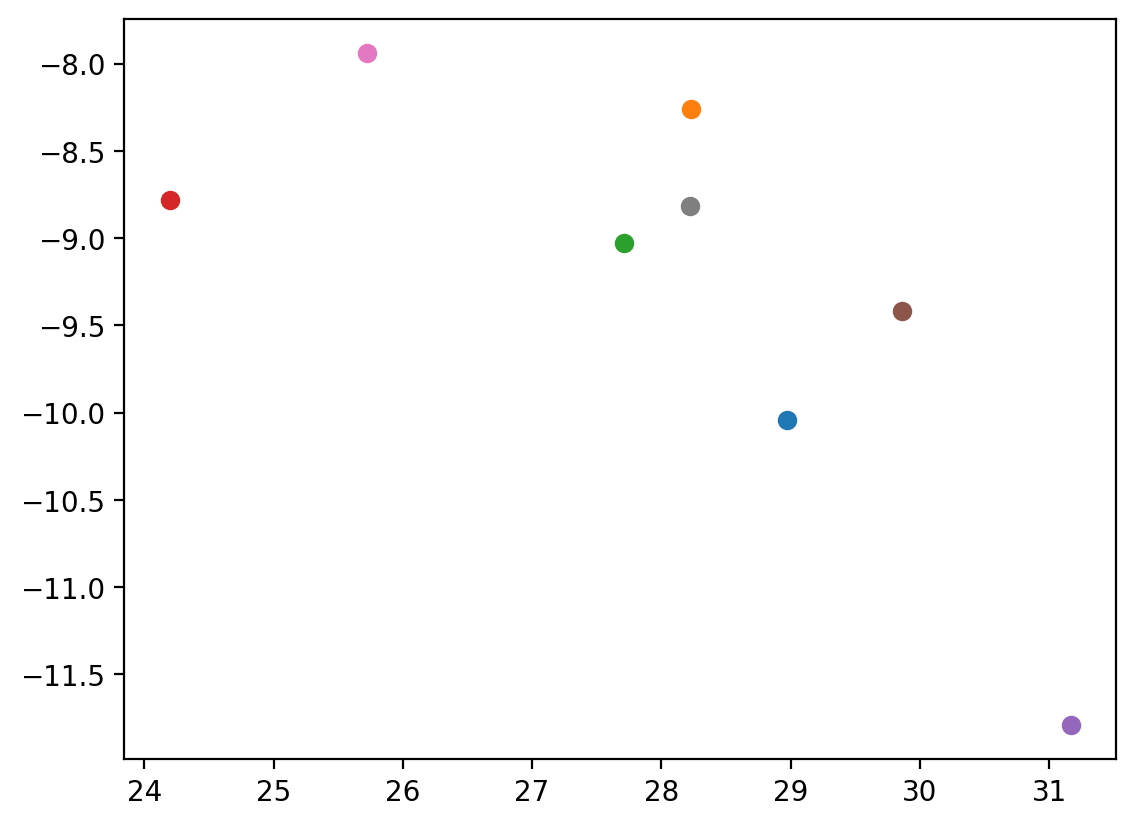

In [113]:
def M2():
    for group in range(len(groups)):
        CG = S1(group)
        eta_n = np.degrees(M1(group, False)[0])
        plt.scatter(CG, eta_n)
M2()

(0.005920894843526718, 0.9120422917585953)

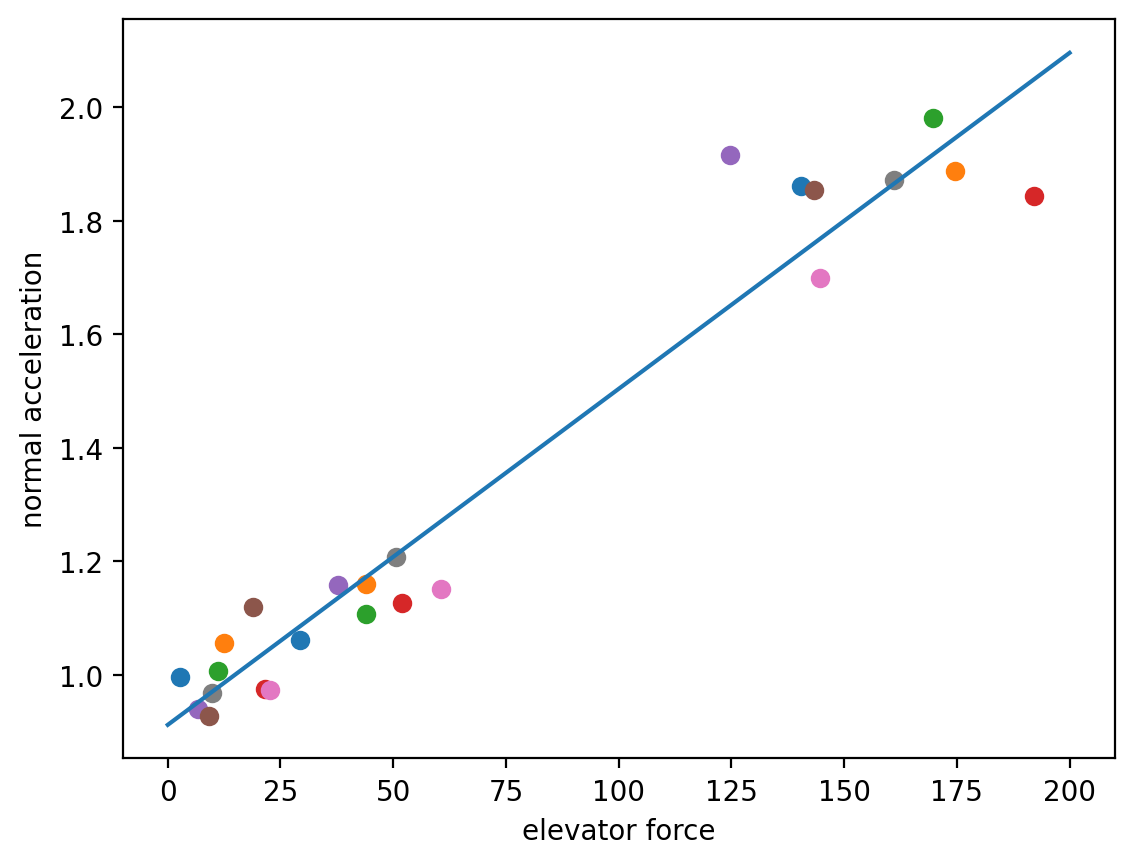

In [114]:
def M3(group, all_groups=True):
    all_eta = []
    all_g = []
    if all_groups:
        for group in range(len(groups)):
            eta = np.array(maneuvre[group]["Elevator Control Force [N]"])
            n = np.array(maneuvre[group]["Normal Acceleration [g]"])
            for e in eta:
                all_eta.append(e)
            for g in n:
                all_g.append(g)
            plt.scatter(eta, n)
            
        plt.xlabel("elevator force")
        plt.ylabel("normal acceleration")
    else:
        eta = np.array(maneuvre[group]["Elevator Control Force [N]"])
        n = np.array(maneuvre[group]["Normal Acceleration [g]"])
        for e in eta:
            all_eta.append(e)
        for g in n:
            all_g.append(g)
    (m, c) = opt.curve_fit(linear, all_eta, all_g)[0]
    
    if all_groups:
        plt.plot(np.linspace(0, 200), linear(np.linspace(0, 200), m, c))
    return (m, c)
M3(3)

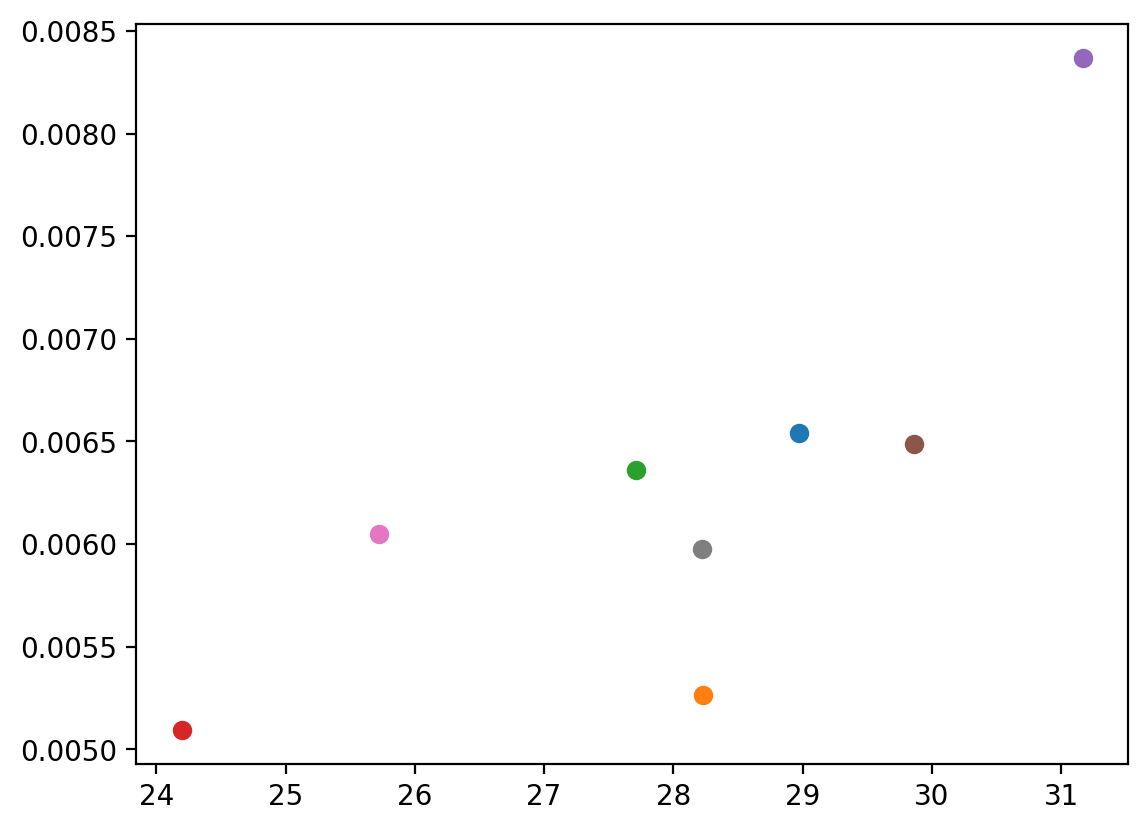

In [115]:
def M4():
    for group in range(len(groups)):
        CG = S1(group)
        eta_n = M3(group, False)[0]
        plt.scatter(CG, eta_n)
M4()

[None, None, None, None, None, None, None, None]

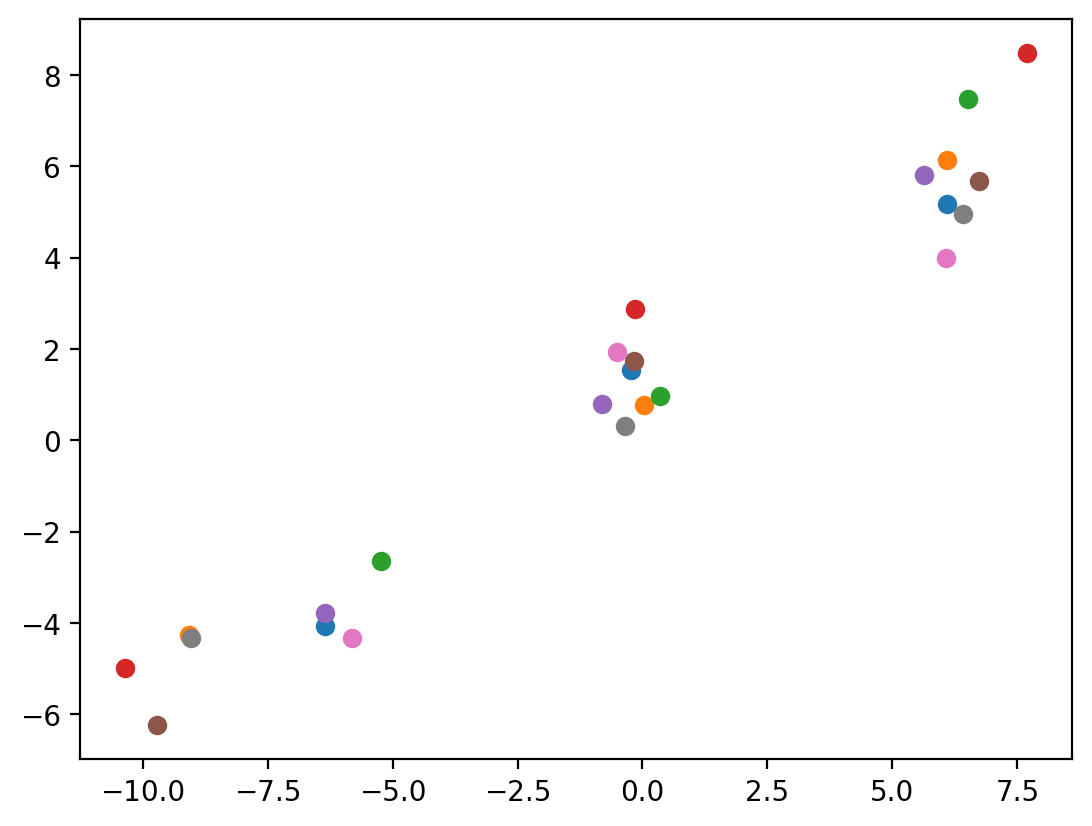

In [123]:
def ldss1(group):
    slip = sideslip[group]["Sideslip Angle [°]"]
    roll = sideslip[group]["Roll Attitude [°]"]
    plt.scatter(slip, roll)
[ldss1(i) for i in range(len(groups))]

In [116]:
sideslip[4]["Sideslip Angle [°]"]

0   -0.8125
1   -6.3509
2    5.6282
Name: Sideslip Angle [°], dtype: float64